### Histogram Equalization on Training Set
Given the varied contrast levels among the X-ray scans in our training set, we apply histogram equalization.   
This technique enhances the contrast by redistributing the intensity values across the image, ensuring consistent visual quality throughout the dataset and optimizing conditions for our ML/DL models.

In [2]:
from PIL import Image
from pathlib import Path
from skimage import exposure, io
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
path = Path('Train/FlipRot/')
path2 = Path('Train/FlipRot_HE//')

In [4]:
scans = list(path.glob("*.png"))
len(scans)

12624

We select the *brightest*, *darkest* and *average* scans in the training set and apply histogram equalization to preview the effectiveness of this preprocessing step.

In [5]:
def average_intensity(image_path):
    img = Image.open(image_path).convert('L')
    img_np = np.asarray(img)  # Convert image to numpy array
    return image_path, np.mean(img_np)

def find_extreme_and_average_intensity_images(image_paths):
    with Pool() as pool:
        intensities = pool.map(average_intensity, image_paths)

    # Sort by intensity
    intensities.sort(key=lambda x: x[1])

    # Find overall average intensity
    overall_avg_intensity = np.mean([intensity for _, intensity in intensities])

    # Find the image with intensity closest to overall average
    avg_intensity_image = min(intensities, key=lambda x: abs(x[1] - overall_avg_intensity))
    return intensities[0], intensities[-1], avg_intensity_image  # darkest, brightest, average

def equalize_histogram(img_path):
    img = io.imread(img_path, as_gray=True)
    img_eh = exposure.equalize_hist(img) * 255
    img = Image.fromarray(img_eh.astype(np.uint8))
    return img

def plot_images(original_paths):
    fig, ax = plt.subplots(3, 2, figsize=(10, 8))
    ax[0, 0].set_title("Original")
    ax[0, 1].set_title("Equalized")

    for i, path in enumerate(original_paths):
        # Original Image
        orig_img = Image.open(path).convert('L')
        orig_img.thumbnail((256,256))
        ax[i, 0].imshow(orig_img, cmap='gray')
        ax[i, 0].axis('off')

        # Equalized Image
        equalized_img = equalize_histogram(path)
        ax[i, 1].imshow(equalized_img, cmap='gray')
        ax[i, 1].axis('off')

    # Tight layout
    plt.tight_layout()
    plt.show()

In [6]:
darkest, brightest, average_img = find_extreme_and_average_intensity_images(scans)

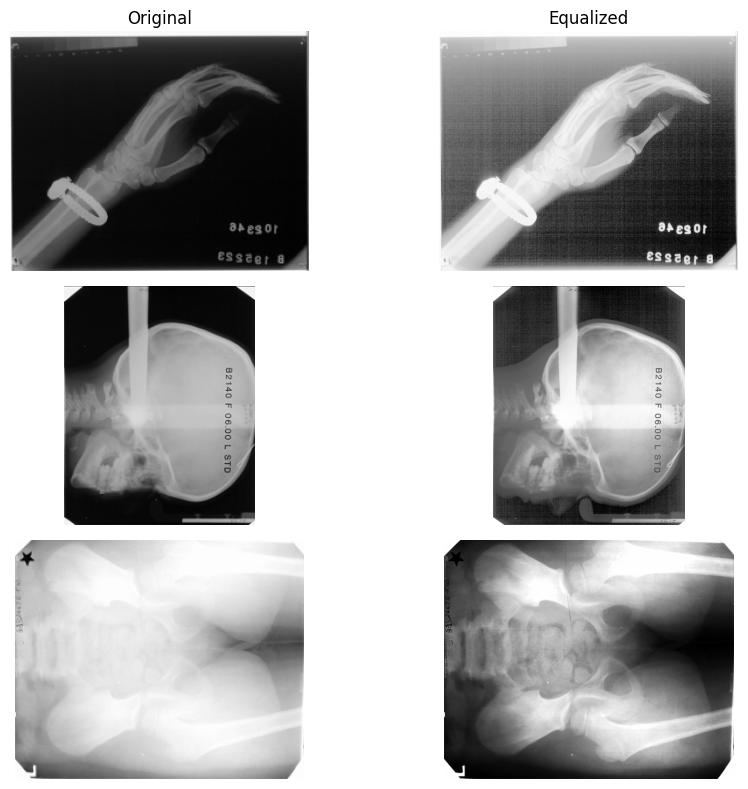

In [7]:
selected_images = [darkest[0], average_img[0], brightest[0]]
plot_images(selected_images)

Finally we apply histogram equalization to the entire training set.

In [8]:
def image_he(file_path):
    try:
        img = io.imread(file_path, as_gray=True)
        img_eh = exposure.equalize_hist(img) * 255
        img = Image.fromarray(img_eh.astype(np.uint8))
        img.save(path2/file_path.name)
    except Exception as e:
        print(f"{file_path.resolve()}: {e}")

In [9]:
with Pool() as p:
    p.map(image_he, scans)